# SGDClassifier训练+分析
> 从头到尾，训练分析过一遍
- 预处理
- 全数据集训练

In [1]:
# to build and test ml model

# Common imports 
import sys

import sklearn

import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# 加载mnist数据集
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# 利用预先划分好的训练集和测试集

X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [104]:
# 预处理+验证
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

# 预处理
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# fit_transform类似于对输入进行标准化，归一化

# 全训练集——训练
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train)
# 训练耗时差不多5min

SGDClassifier(random_state=42)

In [105]:
# 模型保存
import joblib
joblib.dump(sgd_clf,"sgd_model_all_training.pkl")
# to load
# sgd_model_all_training_loaded = joblib.load("sgd_model_all_training.pkl")

['sgd_model_all_training.pkl']

In [93]:
# 测试集预处理
X_test_pred = scaler.fit_transform(X_test.astype(np.float64))

In [106]:
# 简单的用测试集验证---训练后，个人简单验证
# 检验函数
def testour(X_test,y_test,n,model,scaler):
    some_digit=X_test[n]
    some_digit_pred = model.predict([some_digit])
    print("test result: predict:"+str(some_digit_pred)+' real: '+str(y_test[n]))
    some_digit_score=model.decision_function([some_digit])
    print("test scores:"+str(some_digit_score))

testour(X_train,y_test,100,sgd_clf,scaler)

test result: predict:['8'] real: 6
test scores:[[-28525.77056003 -15240.76747086  -6675.30016507  -7353.83042165
   -8760.74615412   -348.04181407 -12777.19183329 -11494.15436858
     631.05196772  -1012.21981369]]


In [ ]:
# 对训练/测试集调用fit_transform后，我没法将同样的变换用于单个输入
# 即使能变换，但是差异很大，所以打算将新数据插入到测试集，整体变换后，提取出来再预测

In [58]:
# single_test 等于实际要预测的数据
X_test_copy = X_test
X_test_copy = np.append(X_test_copy,[single_test],axis=0)
X_test_copy_pred = scaler.fit_transform(X_test_copy_pred.astype(np.float64))
# 添加到末尾
print(sgd_clf.predict(X_test_copy_pred[10000]))

(1, 784)


In [83]:
# 单个数据，标准化后不准
test_array = np.array([single_test])
test_array_pred = scaler.fit_transform(test_array.astype(np.float64))

## 性能检验

In [107]:
from sklearn.model_selection import cross_val_score
# 交叉验证——比较准确率
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")
# 全数据集交叉验证差不多12min
# 输入简单缩放后，准确率/交叉验证分数提高了不少。。。

array([0.87365, 0.85835, 0.8689 ])

### 计算混淆矩阵|精度,召回率,f1分数

In [108]:
# 写一个简化操作的函数--------------------------------计算不同分类模型的...如上
# 导入相关函数
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
# 当前环境需要有 X_train,y_train

# 参数：model——训练好的算法模型；name——用于显示的名字；暂时固定训练集和标签数量
def calcualte_conmat_pr_rc_f1(model,name=''):
    # 计算混淆矩阵前，先要预测一轮
    y_train_pred = cross_val_predict(model,X_train,y_train,cv=3)
    # 计算混淆矩阵，并打印
    con_mat_model = confusion_matrix(y_train,y_train_pred)
    print(name+' 混淆矩阵为：')
    print(con_mat_model)
    # 计算召回率和精度
    # 美化显示的数字
    def display_cutnum(x):
        if len(x)<10:
            x = x +'0'*(10-len(x))
        else:
            x = x[:10]
        return x
    # 计算每一个，并且添加到列表里
    pr_rc_f1_list=[]
    vertical_sum = con_mat_model.sum(axis=0)
    for i in range(10):
        tp = max(con_mat_model[i])
        fp = sum(con_mat_model[i])-tp
        fn = vertical_sum[i]-tp
        pr = tp/(tp+fp)
        rc = tp/(tp+fn)
        f1 = tp/(tp+(fn+fp)/2)
        pr_rc_f1_list.append([pr,rc,f1])
    print('\n各个数字的精度，召回率和f1分数分别如下：\n')
    for i in range(10):
        num = str(i)
        pr = display_cutnum(str(pr_rc_f1_list[i][0]))
        rc = display_cutnum(str(pr_rc_f1_list[i][1]))
        f1 = display_cutnum(str(pr_rc_f1_list[i][2]))
        print('数字 '+num+' 的精度为：'+pr+' 召回率为：'+rc+' f1分数为：'+f1+'\n')
# 测试
calcualte_conmat_pr_rc_f1(sgd_clf,'sgd')
# 跑整个训练集大概4-5min

sgd 混淆矩阵为：
[[5635    0   61   10   16   50   46    7   66   32]
 [   3 6393   95   21   16   47   15   27  109   16]
 [  72   56 5174   89   69   39  163   66  212   18]
 [  58   32  217 4941   23  441   32   56  216  115]
 [  11   26   46    6 5298   26   73   32   87  237]
 [  68   23   58  150   83 4606  174   26  152   81]
 [  40   13   56    6   22  113 5625    5   36    2]
 [  23   24  103   36  124   40   10 5228   75  602]
 [  40  101  158  122   49  457   77   35 4666  146]
 [  33   18   66   83  515  127    4  485  166 4452]]

各个数字的精度，召回率和f1分数分别如下：

数字 0 的精度为：0.95137599 召回率为：0.94183519 f1分数为：0.94658155

数字 1 的精度为：0.94823494 召回率为：0.95617708 f1分数为：0.95218945

数字 2 的精度为：0.86841221 召回率为：0.85747431 f1分数为：0.86290860

数字 3 的精度为：0.80590442 召回率为：0.90428257 f1分数为：0.85226390

数字 4 的精度为：0.90688120 召回率为：0.85245374 f1分数为：0.87882557

数字 5 的精度为：0.84965873 召回率为：0.77463841 f1分数为：0.81041611

数字 6 的精度为：0.95049003 召回率为：0.90448625 f1分数为：0.92691768

数字 7 的精度为：0.83447725 召回率为：0.87615217 f1分数为：0.8548

### 绘制阈值与精度|召回率的曲线图

[False  True False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False  True ... False False False]
[ True False False ...  True False False]
[False False False ... False  True False]
[False False False ... False False False]
[False False False ... False False  True]
[False False False ... False False False]
数字 0 的阈值——精度/召回率曲线图：



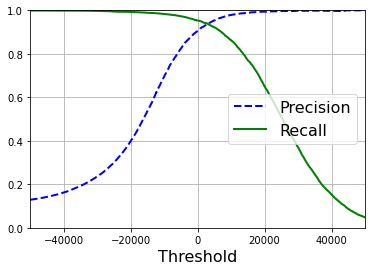

<Figure size 576x288 with 0 Axes>

数字 1 的阈值——精度/召回率曲线图：



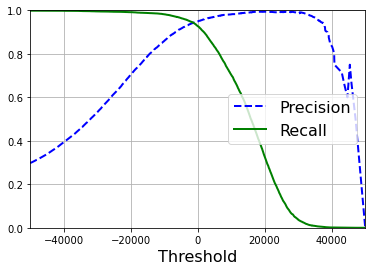

<Figure size 576x288 with 0 Axes>

数字 2 的阈值——精度/召回率曲线图：



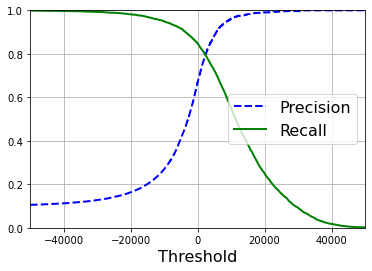

<Figure size 576x288 with 0 Axes>

数字 3 的阈值——精度/召回率曲线图：



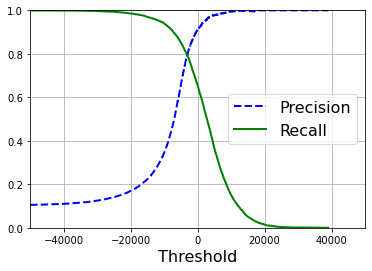

<Figure size 576x288 with 0 Axes>

数字 4 的阈值——精度/召回率曲线图：



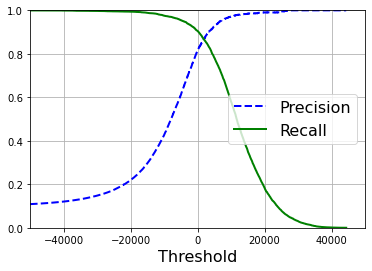

<Figure size 576x288 with 0 Axes>

数字 5 的阈值——精度/召回率曲线图：



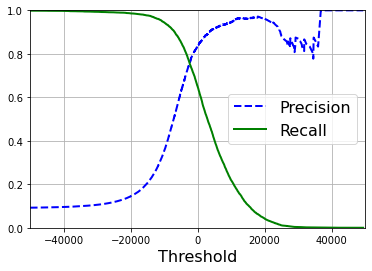

<Figure size 576x288 with 0 Axes>

数字 6 的阈值——精度/召回率曲线图：



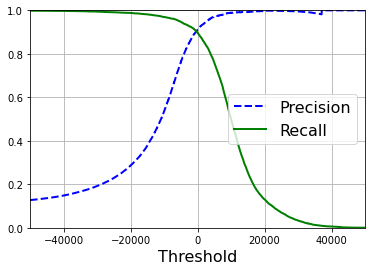

<Figure size 576x288 with 0 Axes>

数字 7 的阈值——精度/召回率曲线图：



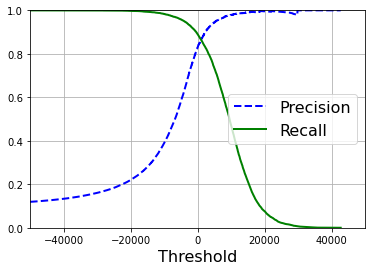

<Figure size 576x288 with 0 Axes>

数字 8 的阈值——精度/召回率曲线图：



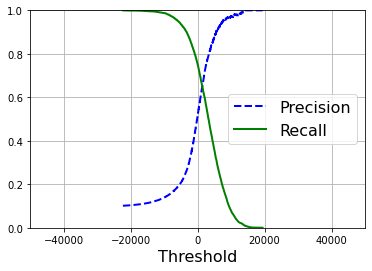

<Figure size 576x288 with 0 Axes>

数字 9 的阈值——精度/召回率曲线图：



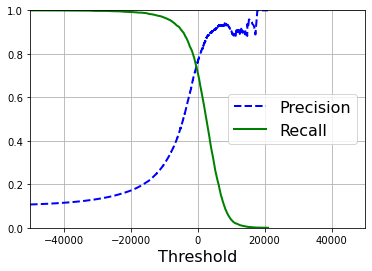

<Figure size 576x288 with 0 Axes>

0

In [109]:
# 绘制阈值与精度|召回率的曲线图--------------可选不同算法模型
# 导入所需模型
from sklearn.linear_model import SGDClassifier
# 导入相关函数
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
# 当前环境要有:X_train,y_train

# 画图
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown
    plt.figure(figsize=(8, 4))                  # Not shown

# plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# plt.show()

# 画出每个数字的阈值——精度/召回率曲线
def draw_num_pr_threshold(model):
    # 先给各个数字分类
    y_train_set = []
    model_list = []
    y_scores_set = []
    pr_curve_set = []
    for i in range(10):
        y_train_set.append(y_train==str(i))
        print(y_train_set[i])
    # 模型可以直接用,无需重复训练
    for i in range(10):
        y_scores_set.append(cross_val_predict(model, X_train, y_train_set[i], cv=3,method="decision_function"))
    for i in range(10):
        precisions, recalls, thresholds = precision_recall_curve(y_train_set[i], y_scores_set[i])
        pr_curve_set.append([precisions, recalls, thresholds])
    for i in range(10):
        print('数字 '+str(i)+' 的阈值——精度/召回率曲线图：\n')
        plot_precision_recall_vs_threshold(pr_curve_set[i][0], pr_curve_set[i][1], pr_curve_set[i][2])
        plt.show()
    return 0

draw_num_pr_threshold(sgd_clf)
# 训练大概5-6min

# 绘制ROC曲线
- 用来比较多个模型
- ROC分数/ROC曲线

数字 0 的ROC曲线如下,对应的ROC分数为: 0.9951089652363219



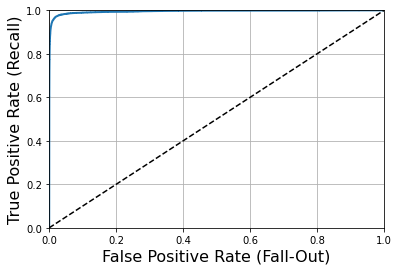

<Figure size 576x432 with 0 Axes>

数字 1 的ROC曲线如下,对应的ROC分数为: 0.9966048806769584



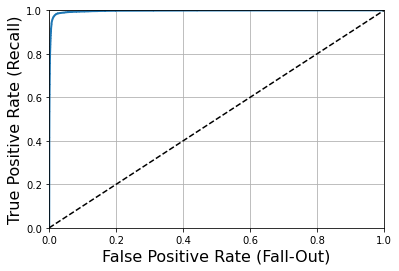

<Figure size 576x432 with 0 Axes>

数字 2 的ROC曲线如下,对应的ROC分数为: 0.9568395257681235



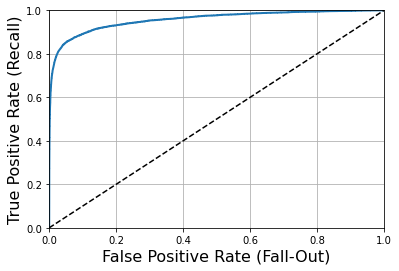

<Figure size 576x432 with 0 Axes>

数字 3 的ROC曲线如下,对应的ROC分数为: 0.9599243001892759



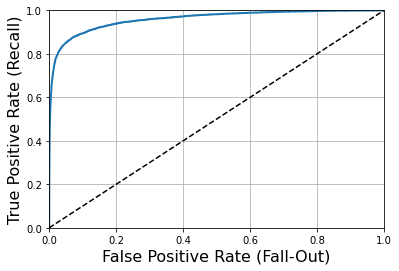

<Figure size 576x432 with 0 Axes>

数字 4 的ROC曲线如下,对应的ROC分数为: 0.9859276923382874



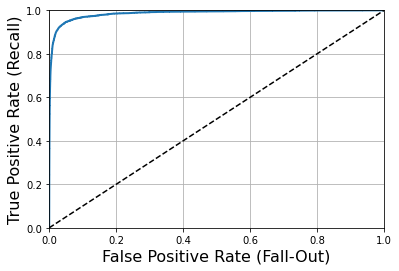

<Figure size 576x432 with 0 Axes>

数字 5 的ROC曲线如下,对应的ROC分数为: 0.9604938554008616



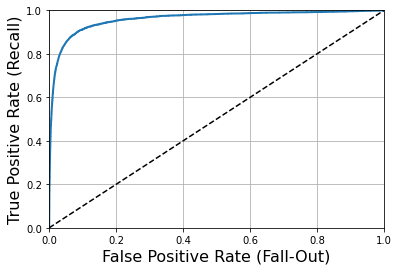

<Figure size 576x432 with 0 Axes>

数字 6 的ROC曲线如下,对应的ROC分数为: 0.9878749264865954



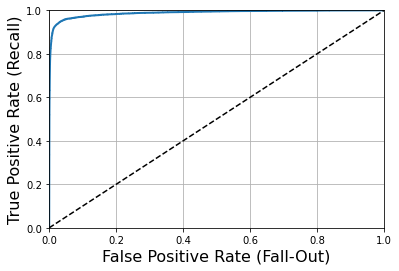

<Figure size 576x432 with 0 Axes>

数字 7 的ROC曲线如下,对应的ROC分数为: 0.986670497551944



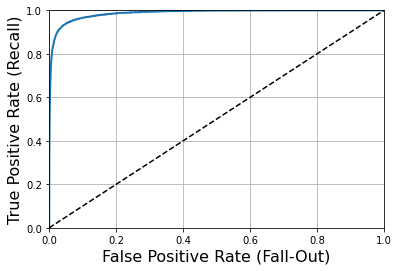

<Figure size 576x432 with 0 Axes>

数字 8 的ROC曲线如下,对应的ROC分数为: 0.9192599874103056



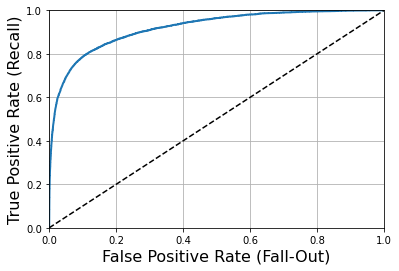

<Figure size 576x432 with 0 Axes>

数字 9 的ROC曲线如下,对应的ROC分数为: 0.96114559368217



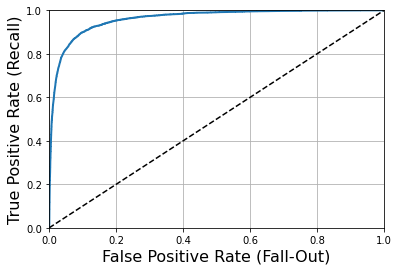

<Figure size 576x432 with 0 Axes>

In [110]:
# 写一个绘制某种model的每个数字ROC曲线的函数--------------用来比较不同的算法模型

# 导入依赖
from sklearn.metrics import roc_curve,roc_auc_score
# 当前环境要有:X_train,y_train

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


# 画图
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown
    plt.figure(figsize=(8, 6))                                # Not shown

def draw_model_roc(model):
    # 先给各个数字分类
    y_train_set = []
    model_list = []
    y_scores_set = []
    roc_curve_set = []
    for i in range(10):
        y_train_set.append(y_train==str(i))
    for i in range(10):
        y_scores = cross_val_predict(model, X_train, y_train_set[i], cv=3,method="decision_function")
        y_scores_set.append(y_scores)
    for i in range(10):
        fpr, tpr, thresholds = roc_curve(y_train_set[i], y_scores_set[i])
        roc_curve_set.append([fpr, tpr, thresholds])
    for i in range(10):
        fpr = roc_curve_set[i][0]
        tpr = roc_curve_set[i][1]
        roc_score = roc_auc_score(y_train_set[i],y_scores_set[i])
        print('数字 '+str(i)+' 的ROC曲线如下,对应的ROC分数为: '+str(roc_score)+'\n')
        plot_roc_curve(fpr, tpr)
        plt.show()

draw_model_roc(sgd_clf)
# sgd_clf----2000左右,大概跑4min---搭配 X_train,y_train_i